<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [2]:
import logging

logging.disable(level=logging.WARNING)

In [3]:
!pip install etna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.3/304.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [4]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [5]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 17.2MB/s]                   


Взглянем на то, что представляют из себя данные:

In [ ]:
df.head()

Date   CashIn  CashOut
4  1/5/2016  20840.0  22200.0
5  1/6/2016  28460.0  18810.0
6  1/7/2016  19250.0  23210.0
7  1/8/2016  49770.0   4350.0
8  1/9/2016      NaN      NaN

В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [6]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?


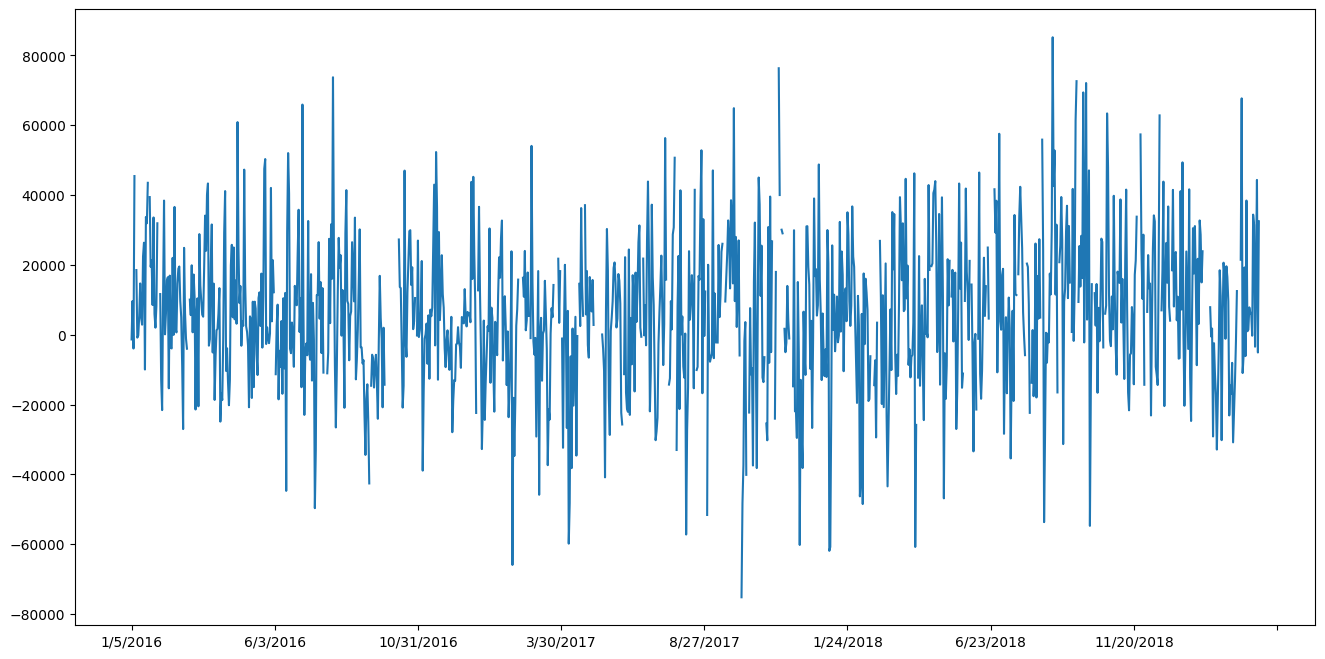

In [ ]:
plt.figure(figsize=[16, 8])
ax = plt.axes()
ax.plot(df['Date'], df['target'])
ax.axes.xaxis.set_major_locator(plt.MaxNLocator(10))

Отрисуем погодовые графики для нахождения внутригодовой сезонности и тренда, если они есть.

In [ ]:
df.shape[0]/365 # столько лет в датасете

3.2383561643835614

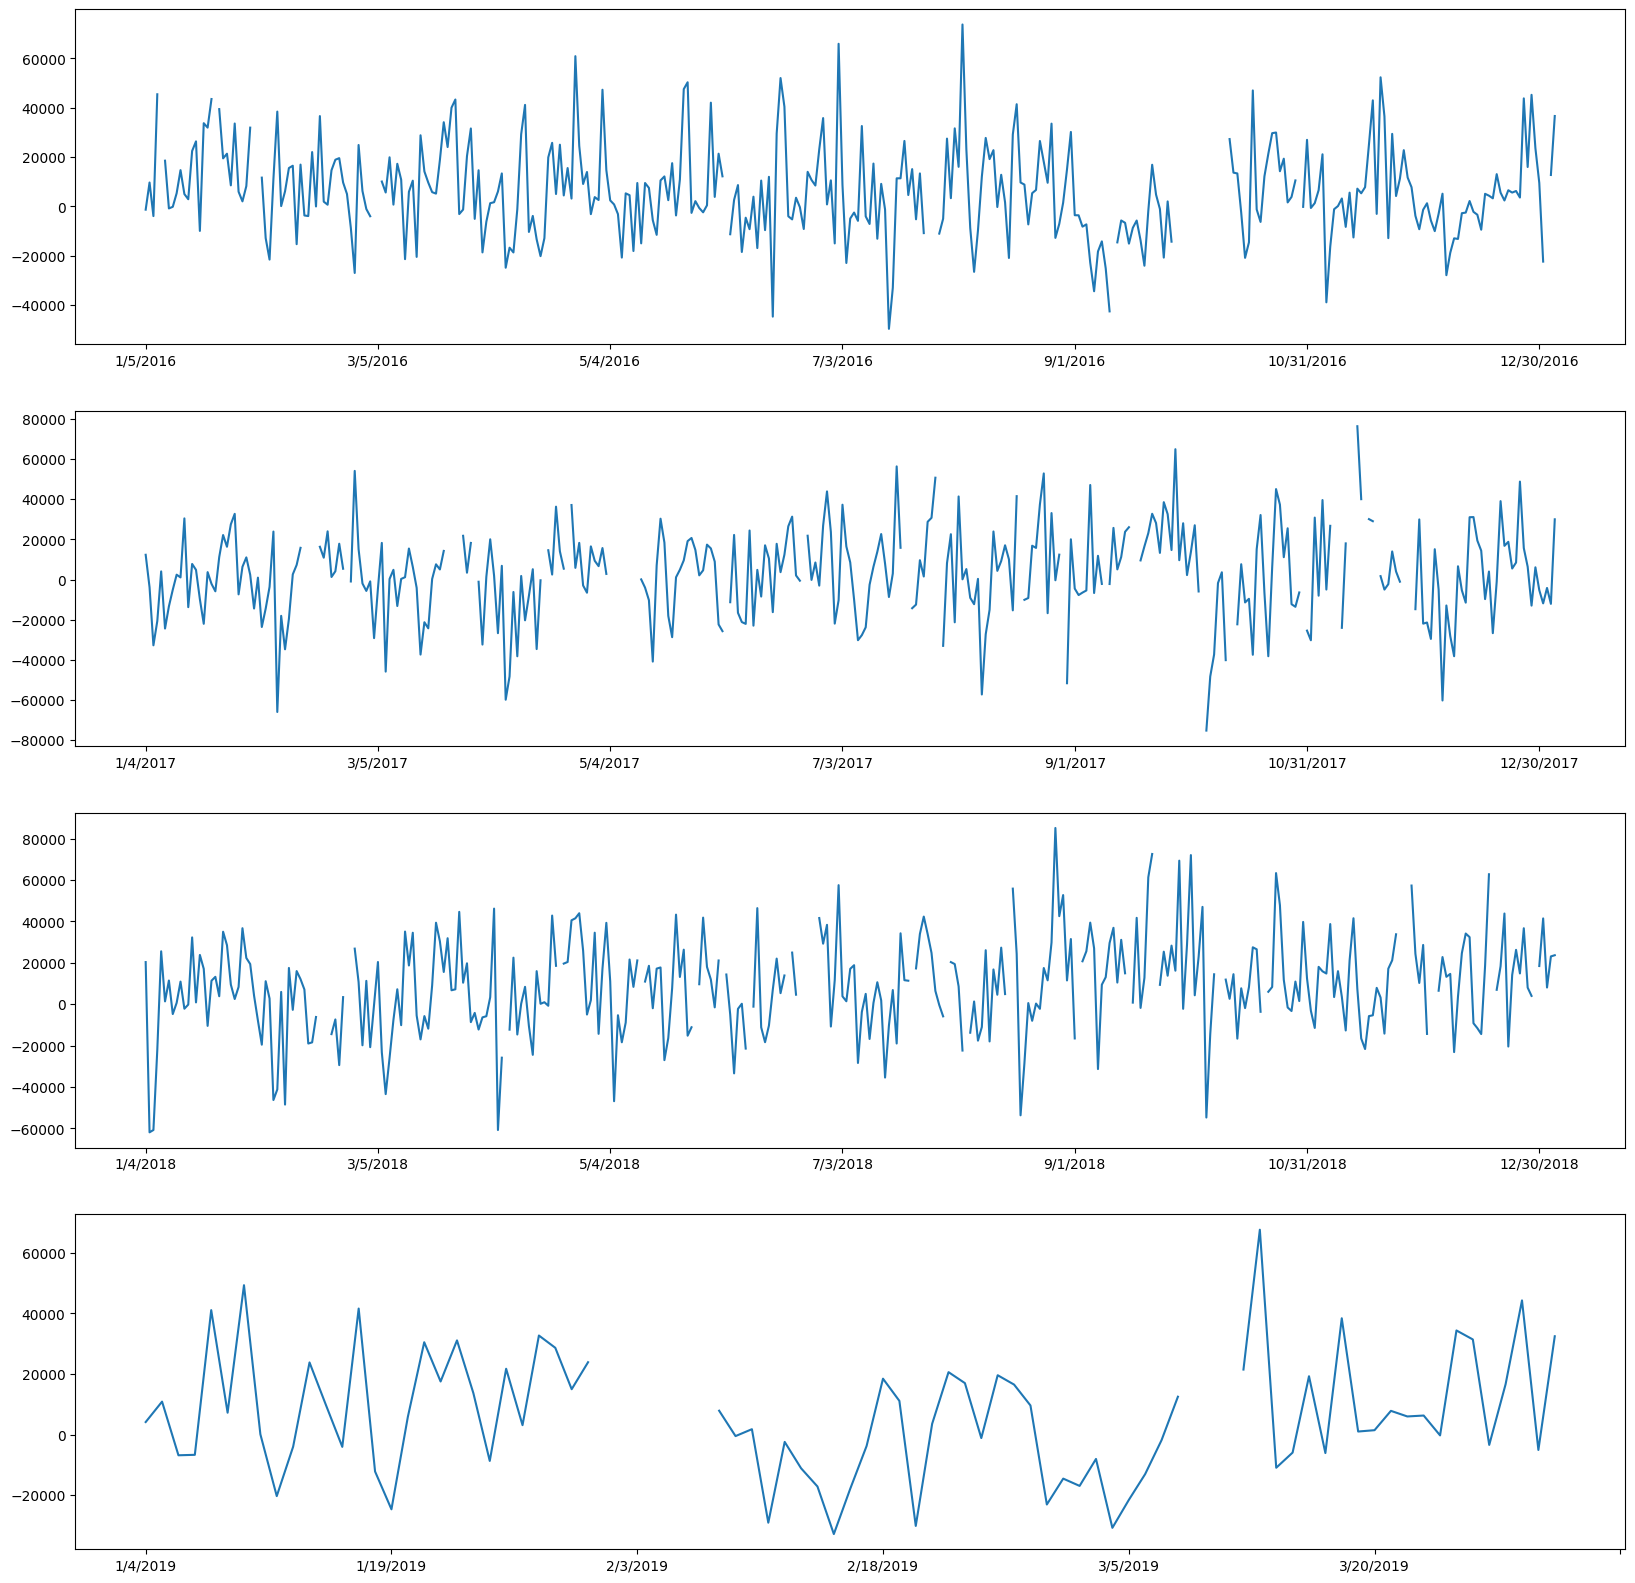

In [ ]:
fig, ax = plt.subplots(4, figsize=[20, 20])

ax[0].axes.xaxis.set_major_locator(plt.MaxNLocator(7))
ax[1].axes.xaxis.set_major_locator(plt.MaxNLocator(7))
ax[2].axes.xaxis.set_major_locator(plt.MaxNLocator(7))
ax[3].axes.xaxis.set_major_locator(plt.MaxNLocator(7))

ax[0].plot(df.iloc[:365, 0], df.iloc[:365, -1])
ax[1].plot(df.iloc[365: 365*2, 0], df.iloc[365: 365*2, -1])
ax[2].plot(df.iloc[365*2:365*3, 0], df.iloc[365*2:365*3, -1])
ax[3].plot(df.iloc[365*3:, 0], df.iloc[365*3:, -1])

Из увиденного уже можно сделать вывод, что сезонная составляющая внутри года есть, чисто визуально видно, что по 6-7 раз в год есть положительные и отрицательные "выбросы", где под "выбросами" подразумеваются большие изменение нетто в наблюдаениях вследствие сезонности.

Ярко выраженного тренда не наблюдается, вероятно его нет вовсе.

In [ ]:
df.corr('pearson')

CashIn   CashOut    target
CashIn   1.000000 -0.385984  0.618221
CashOut -0.385984  1.000000  0.486470
target   0.618221  0.486470  1.000000

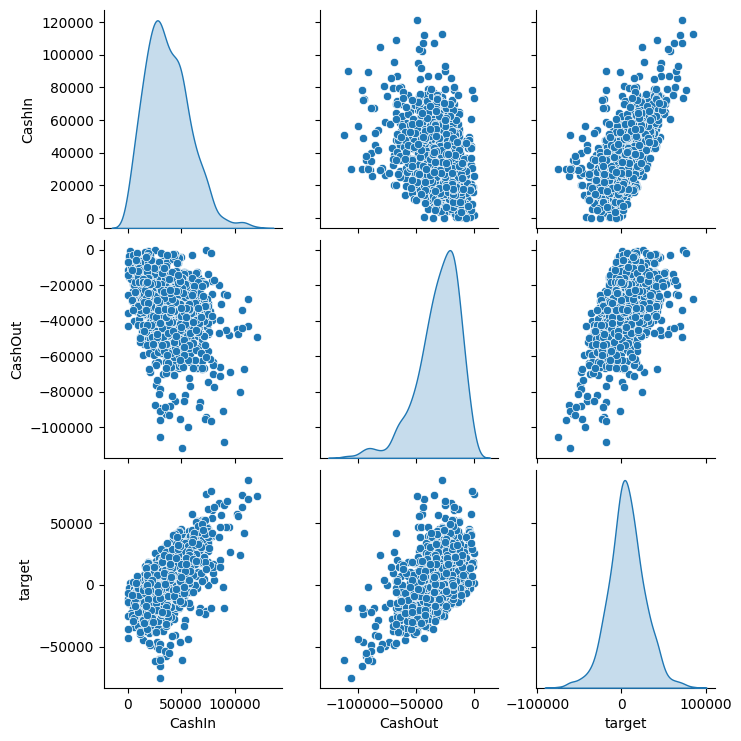

In [ ]:
sns.pairplot(df, diag_kind="kde")

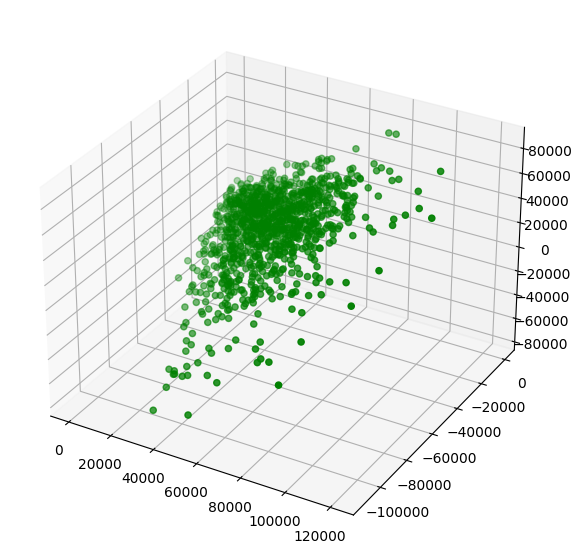

In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
ax.scatter3D(df['CashIn'], df['CashOut'], df['target'], color = "green")

Видно, что все ряды коррелированны друг с другом, слабо коррелированны только депозиты-снятия, оно и понятно. Также скатерплот позволяет увидеть, что совместно величины распределены в соответствии с определенными закономерностями, которые могут быть полезны нам. Как следствие, использование этих рядов для предсказания друг друга более чем оправданно.

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [7]:
from etna.datasets import TSDataset

In [8]:
main_df = pd.melt(df, id_vars=['Date'], value_vars=['CashIn', 'CashOut', 'target'])
main_df.rename(columns = {'Date':'timestamp', 'variable':'segment', 
                          'value':'target'}, inplace = True)
main_df.head()

timestamp segment   target
0  1/5/2016  CashIn  20840.0
1  1/6/2016  CashIn  28460.0
2  1/7/2016  CashIn  19250.0
3  1/8/2016  CashIn  49770.0
4  1/9/2016  CashIn      NaN

In [9]:
df_target = TSDataset.to_dataset(df=main_df[['target', 'segment', 'timestamp']])

df_etna = TSDataset(df=df_target, freq="D", known_future="all")
df_etna.head()

segment      CashIn  CashOut   target
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-09      NaN      NaN      NaN

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

In [ ]:
df.isna().sum(axis=0)

timestamp      0
CashIn       101
CashOut       88
target       110
dtype: int64

In [10]:
from etna.transforms import TimeSeriesImputerTransform

In [11]:
nans = df.iloc[:, 1:].isna()
nans.head()

CashIn  CashOut  target
4   False    False   False
5   False    False   False
6   False    False   False
7   False    False   False
8    True     True    True

In [12]:
# выбрано заполнение сезонной скользящей средней, дабы во-первых,
# исключить утечку данных (как в случае с заполнением обычным средним) и во-вторых,
# сделать поправку на сезонность, которая явно присутствует в данных
fillna = TimeSeriesImputerTransform(strategy='seasonal', window=-1)
fillna.fit_transform(df_etna)
df_etna.head()

segment      CashIn  CashOut   target
feature      target   target   target
timestamp                            
2016-01-05  20840.0 -22200.0  -1360.0
2016-01-06  28460.0 -18810.0   9650.0
2016-01-07  19250.0 -23210.0  -3960.0
2016-01-08  49770.0  -4350.0  45420.0
2016-01-09  29580.0 -17142.5  12437.5

In [90]:
df_etna.describe()

start_timestamp end_timestamp  length  num_missing  num_segments  \
segments                                                                    
CashIn        2016-01-05    2019-03-31    1182            0             3   
CashOut       2016-01-05    2019-03-31    1182            0             3   
target        2016-01-05    2019-03-31    1182            0             3   

          num_exogs  num_regressors  num_known_future freq  
segments                                                    
CashIn            0               0                 0    D  
CashOut           0               0                 0    D  
target            0               0                 0    D

Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

In [13]:
from etna.analysis.outliers import get_anomalies_median, get_anomalies_density
from etna.analysis import plot_anomalies
from etna.transforms import MedianOutliersTransform

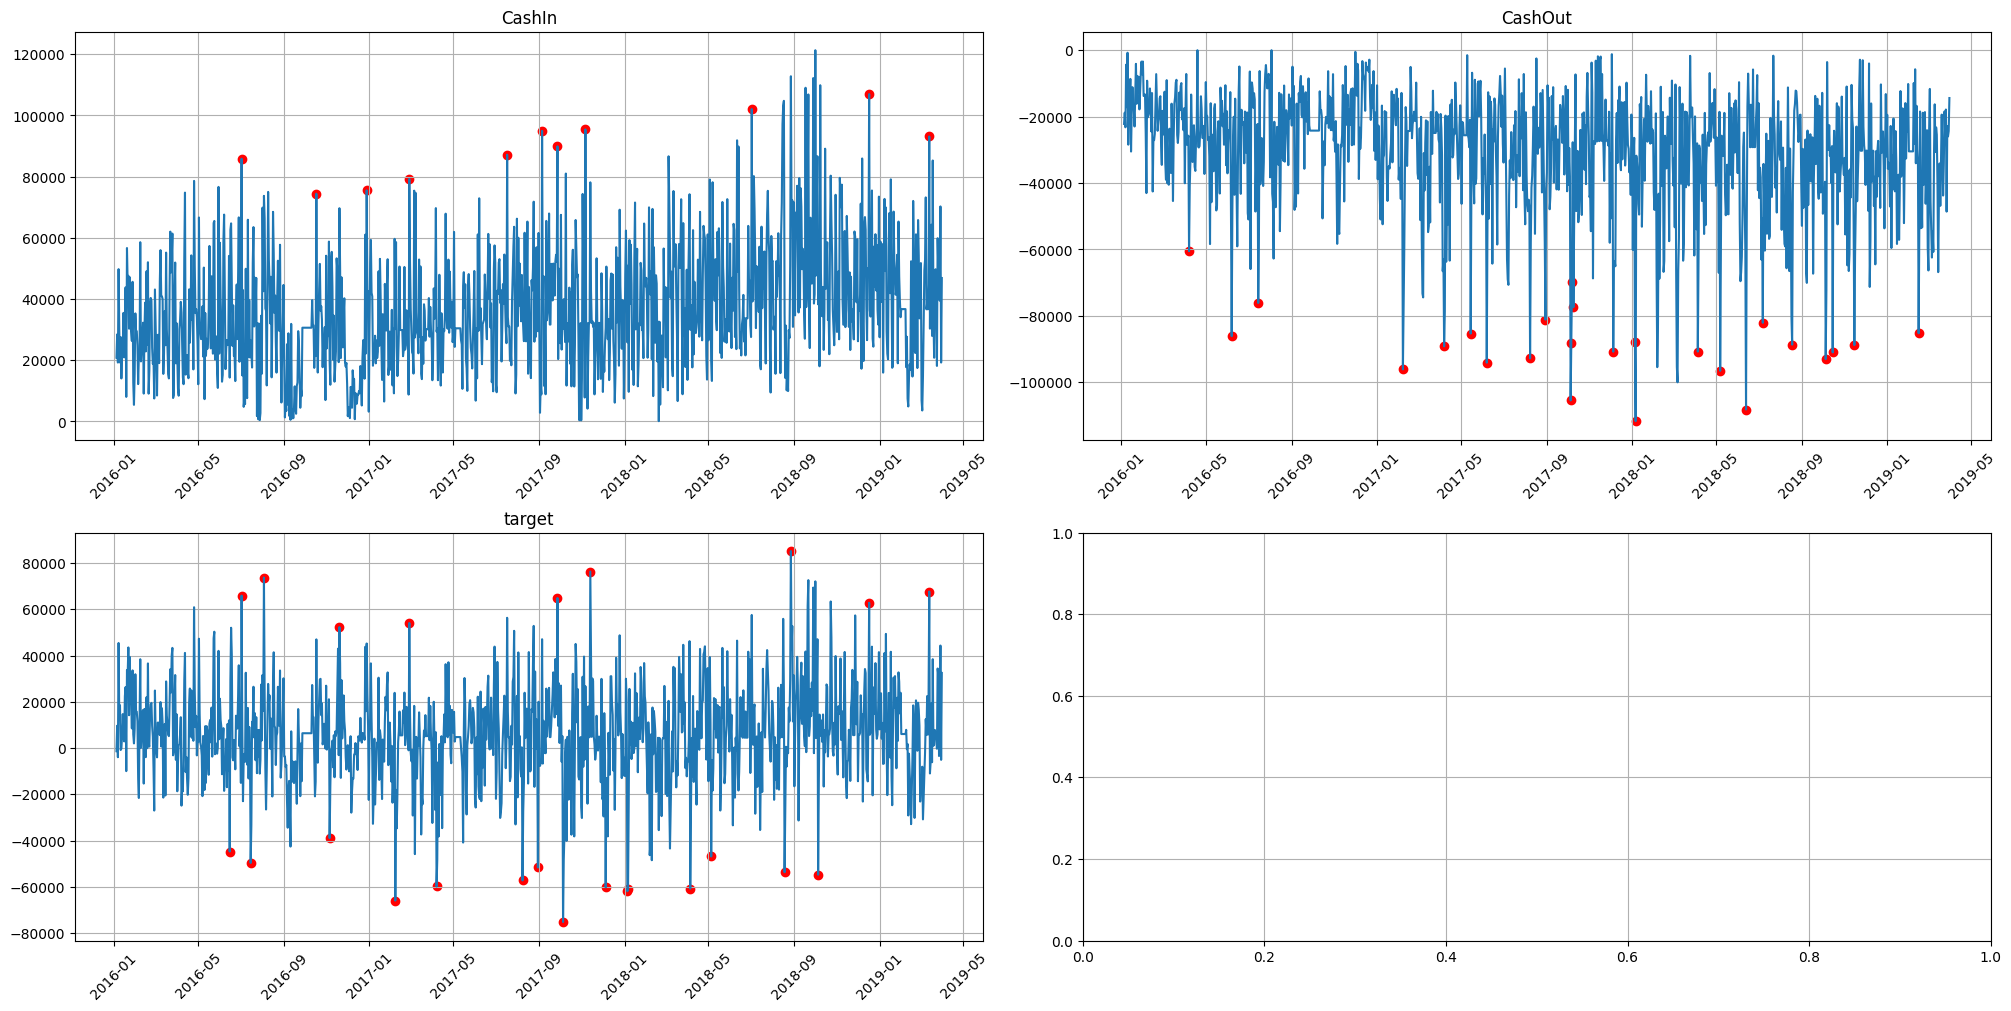

In [14]:
anomalies = get_anomalies_density(df_etna, window_size=30, distance_coef=1, n_neighbors=3)
plot_anomalies(df_etna, anomalies)

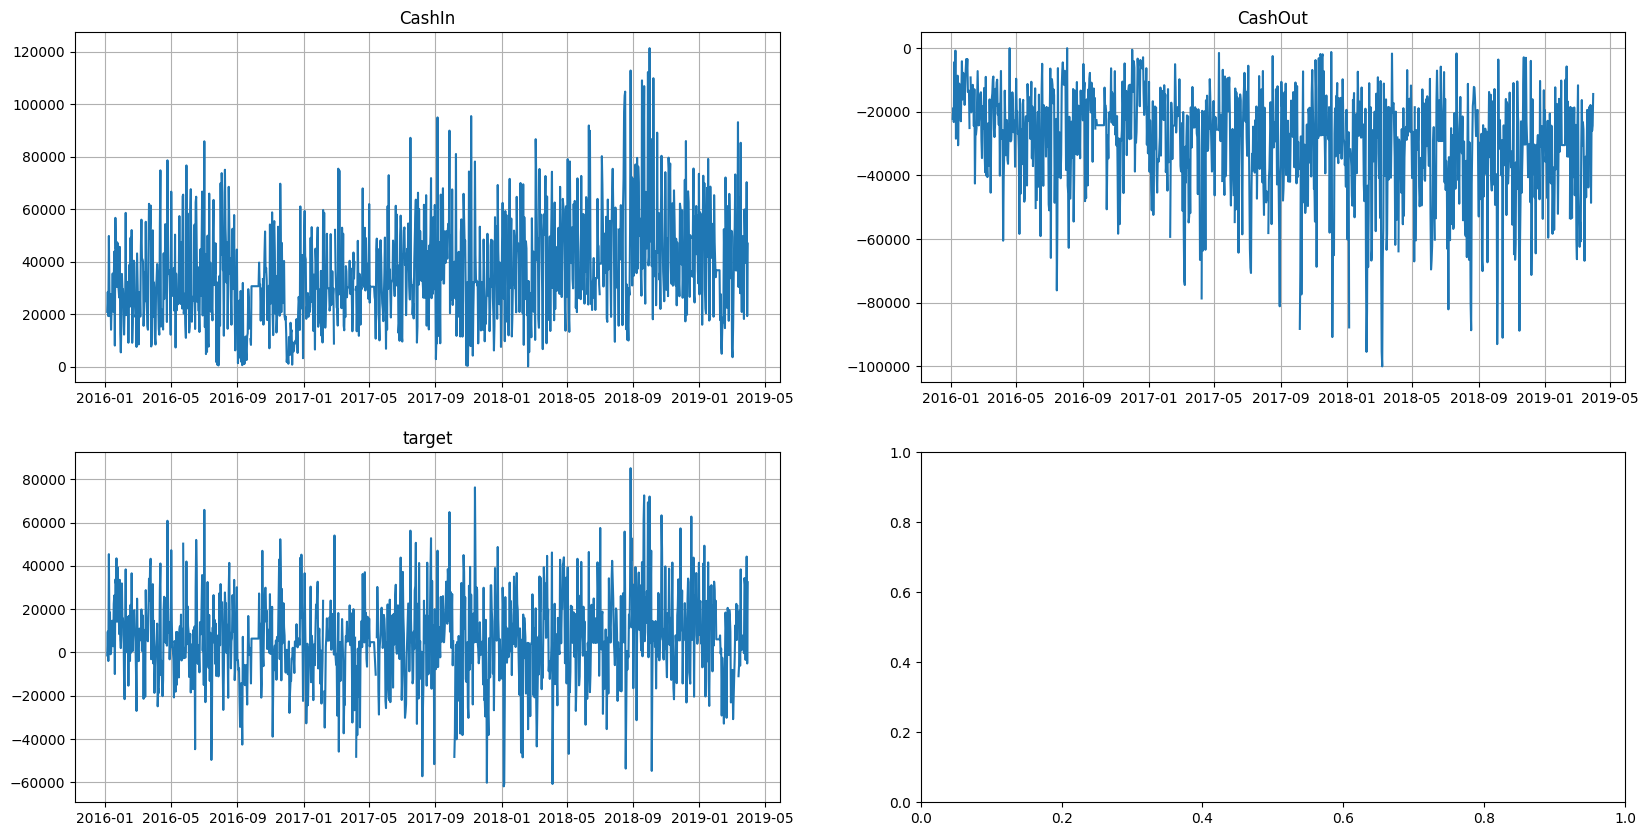

In [15]:
inlier = MedianOutliersTransform(in_column="target", window_size=20)

df_etna.fit_transform([inlier])
df_etna.plot()

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [16]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [17]:
HORIZON = 5

In [18]:
train_ts, test_ts = df_etna.train_test_split(
    train_start="2016-01-01",
    train_end="2019-03-26",
    test_start="2019-03-27",
    test_end="2019-03-31",
)

In [19]:
pipeline = Pipeline(model=ProphetModel())
metrics, forecast, _ = pipeline.backtest(
    ts=train_ts, metrics=[MAE(), SMAPE()], n_folds=6, aggregate_metrics=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elap

Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

In [20]:
metrics

segment           MAE       SMAPE
0   CashIn   6103.798747   17.355930
1  CashOut  10307.698911   33.527131
2   target   9499.104389  103.459322

В соответствии с метрикой SMAPE, модель дает значительно более точные предсказания для CashIn и CashOut, тогда итоговое значение лучше считать, как разницу предсказанных значений CashIn и CashOut (сумма, если CashOut < 0).

В соответствии с метрикой MAE, модель дает таргету более точные предсказания, чем CashOut, а значит следует предсказывать напрямую ряд target.

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [21]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [22]:
df1 = df.copy()
df1["timestamp"] = pd.to_datetime(df1["Date"])
df1.set_index("timestamp", inplace=True)
df1.head()

Date   CashIn  CashOut   target
timestamp                                      
2016-01-05  1/5/2016  20840.0 -22200.0  -1360.0
2016-01-06  1/6/2016  28460.0 -18810.0   9650.0
2016-01-07  1/7/2016  19250.0 -23210.0  -3960.0
2016-01-08  1/8/2016  49770.0  -4350.0  45420.0
2016-01-09  1/9/2016      NaN      NaN      NaN

In [23]:
reason_segments = ['CashIn', 'CashOut']
hierarchical_df = []
periods = df1.shape[0]
for segment_name in reason_segments:
    segment = df1[segment_name]

    segment_slice = pd.DataFrame(
        {"timestamp": segment.index, "target": segment.values, "segment": [segment_name] * periods})
    hierarchical_df.append(segment_slice)

hierarchical_df = pd.concat(hierarchical_df, axis=0)

hierarchical_df.head()

timestamp   target segment
0 2016-01-05  20840.0  CashIn
1 2016-01-06  28460.0  CashIn
2 2016-01-07  19250.0  CashIn
3 2016-01-08  49770.0  CashIn
4 2016-01-09      NaN  CashIn

In [24]:
hierarchical_df = TSDataset.to_dataset(df=hierarchical_df)

#делаем два уровня, таргет и тип действия с деньгами
hierarchical_structure = HierarchicalStructure(
    level_structure={'target': ['CashIn', 'CashOut']}, level_names=["target", "type"])

hierarchical_ts = TSDataset(df=hierarchical_df, freq="D", hierarchical_structure=hierarchical_structure)

hierarchical_ts.head()

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

In [25]:
reconciliator = BottomUpReconciliator(target_level="target", source_level="type")
reconciliator.fit(ts=hierarchical_ts)
reconciliator.mapping_matrix.toarray()

reconciliator.aggregate(ts=hierarchical_ts).head(5)

segment      CashIn  CashOut
feature      target   target
timestamp                   
2016-01-05  20840.0 -22200.0
2016-01-06  28460.0 -18810.0
2016-01-07  19250.0 -23210.0
2016-01-08  49770.0  -4350.0
2016-01-09      NaN      NaN

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

In [26]:
fillna = TimeSeriesImputerTransform(strategy='seasonal', window=-1)
hierarchical_ts.fit_transform([fillna])

inlier = MedianOutliersTransform(in_column="target", window_size=20)
hierarchical_ts.fit_transform([inlier])

pipeline = HierarchicalPipeline(
    model=ProphetModel(),
    reconciliator=BottomUpReconciliator(target_level="target", source_level="type"),
    horizon=HORIZON)

metrics, _, _ = pipeline.backtest(ts=hierarchical_ts, metrics=[MAE()], n_folds=6, aggregate_metrics=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elap

In [27]:
metrics

segment           MAE
0  target  16974.091034

Отлично! Стало значительно хуже! Как я и писал выше, в соответствии с МАЕ, предсказывание таргета через сумму CashIn и CashOut - плохая идея!

### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [28]:
from etna.analysis import acf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostPerSegmentModel,
                         AutoARIMAModel)
from etna.transforms import (STLTransform, LagTransform, 
                             SegmentEncoderTransform, 
                             MeanSegmentEncoderTransform)
from etna.transforms import (DateFlagsTransform, FilterFeaturesTransform,
                             HolidayTransform, LagTransform,
                             LinearTrendTransform, LogTransform, MeanTransform,
                             SegmentEncoderTransform)

In [43]:
df_target = TSDataset.to_dataset(df=main_df[['target', 'segment', 'timestamp']])
df_tag = TSDataset(df=df_target, freq="D", known_future="all")

inlier = MedianOutliersTransform(in_column="target", window_size=20)
df_tag.fit_transform([inlier])

fillna = TimeSeriesImputerTransform(strategy="seasonal", window=-1)
fillna.fit_transform(df_tag)

train_ts, test_ts = df_tag.train_test_split(
    train_start="2016-01-01",
    train_end="2019-03-26",
    test_start="2019-03-27",
    test_end="2019-03-31",
)

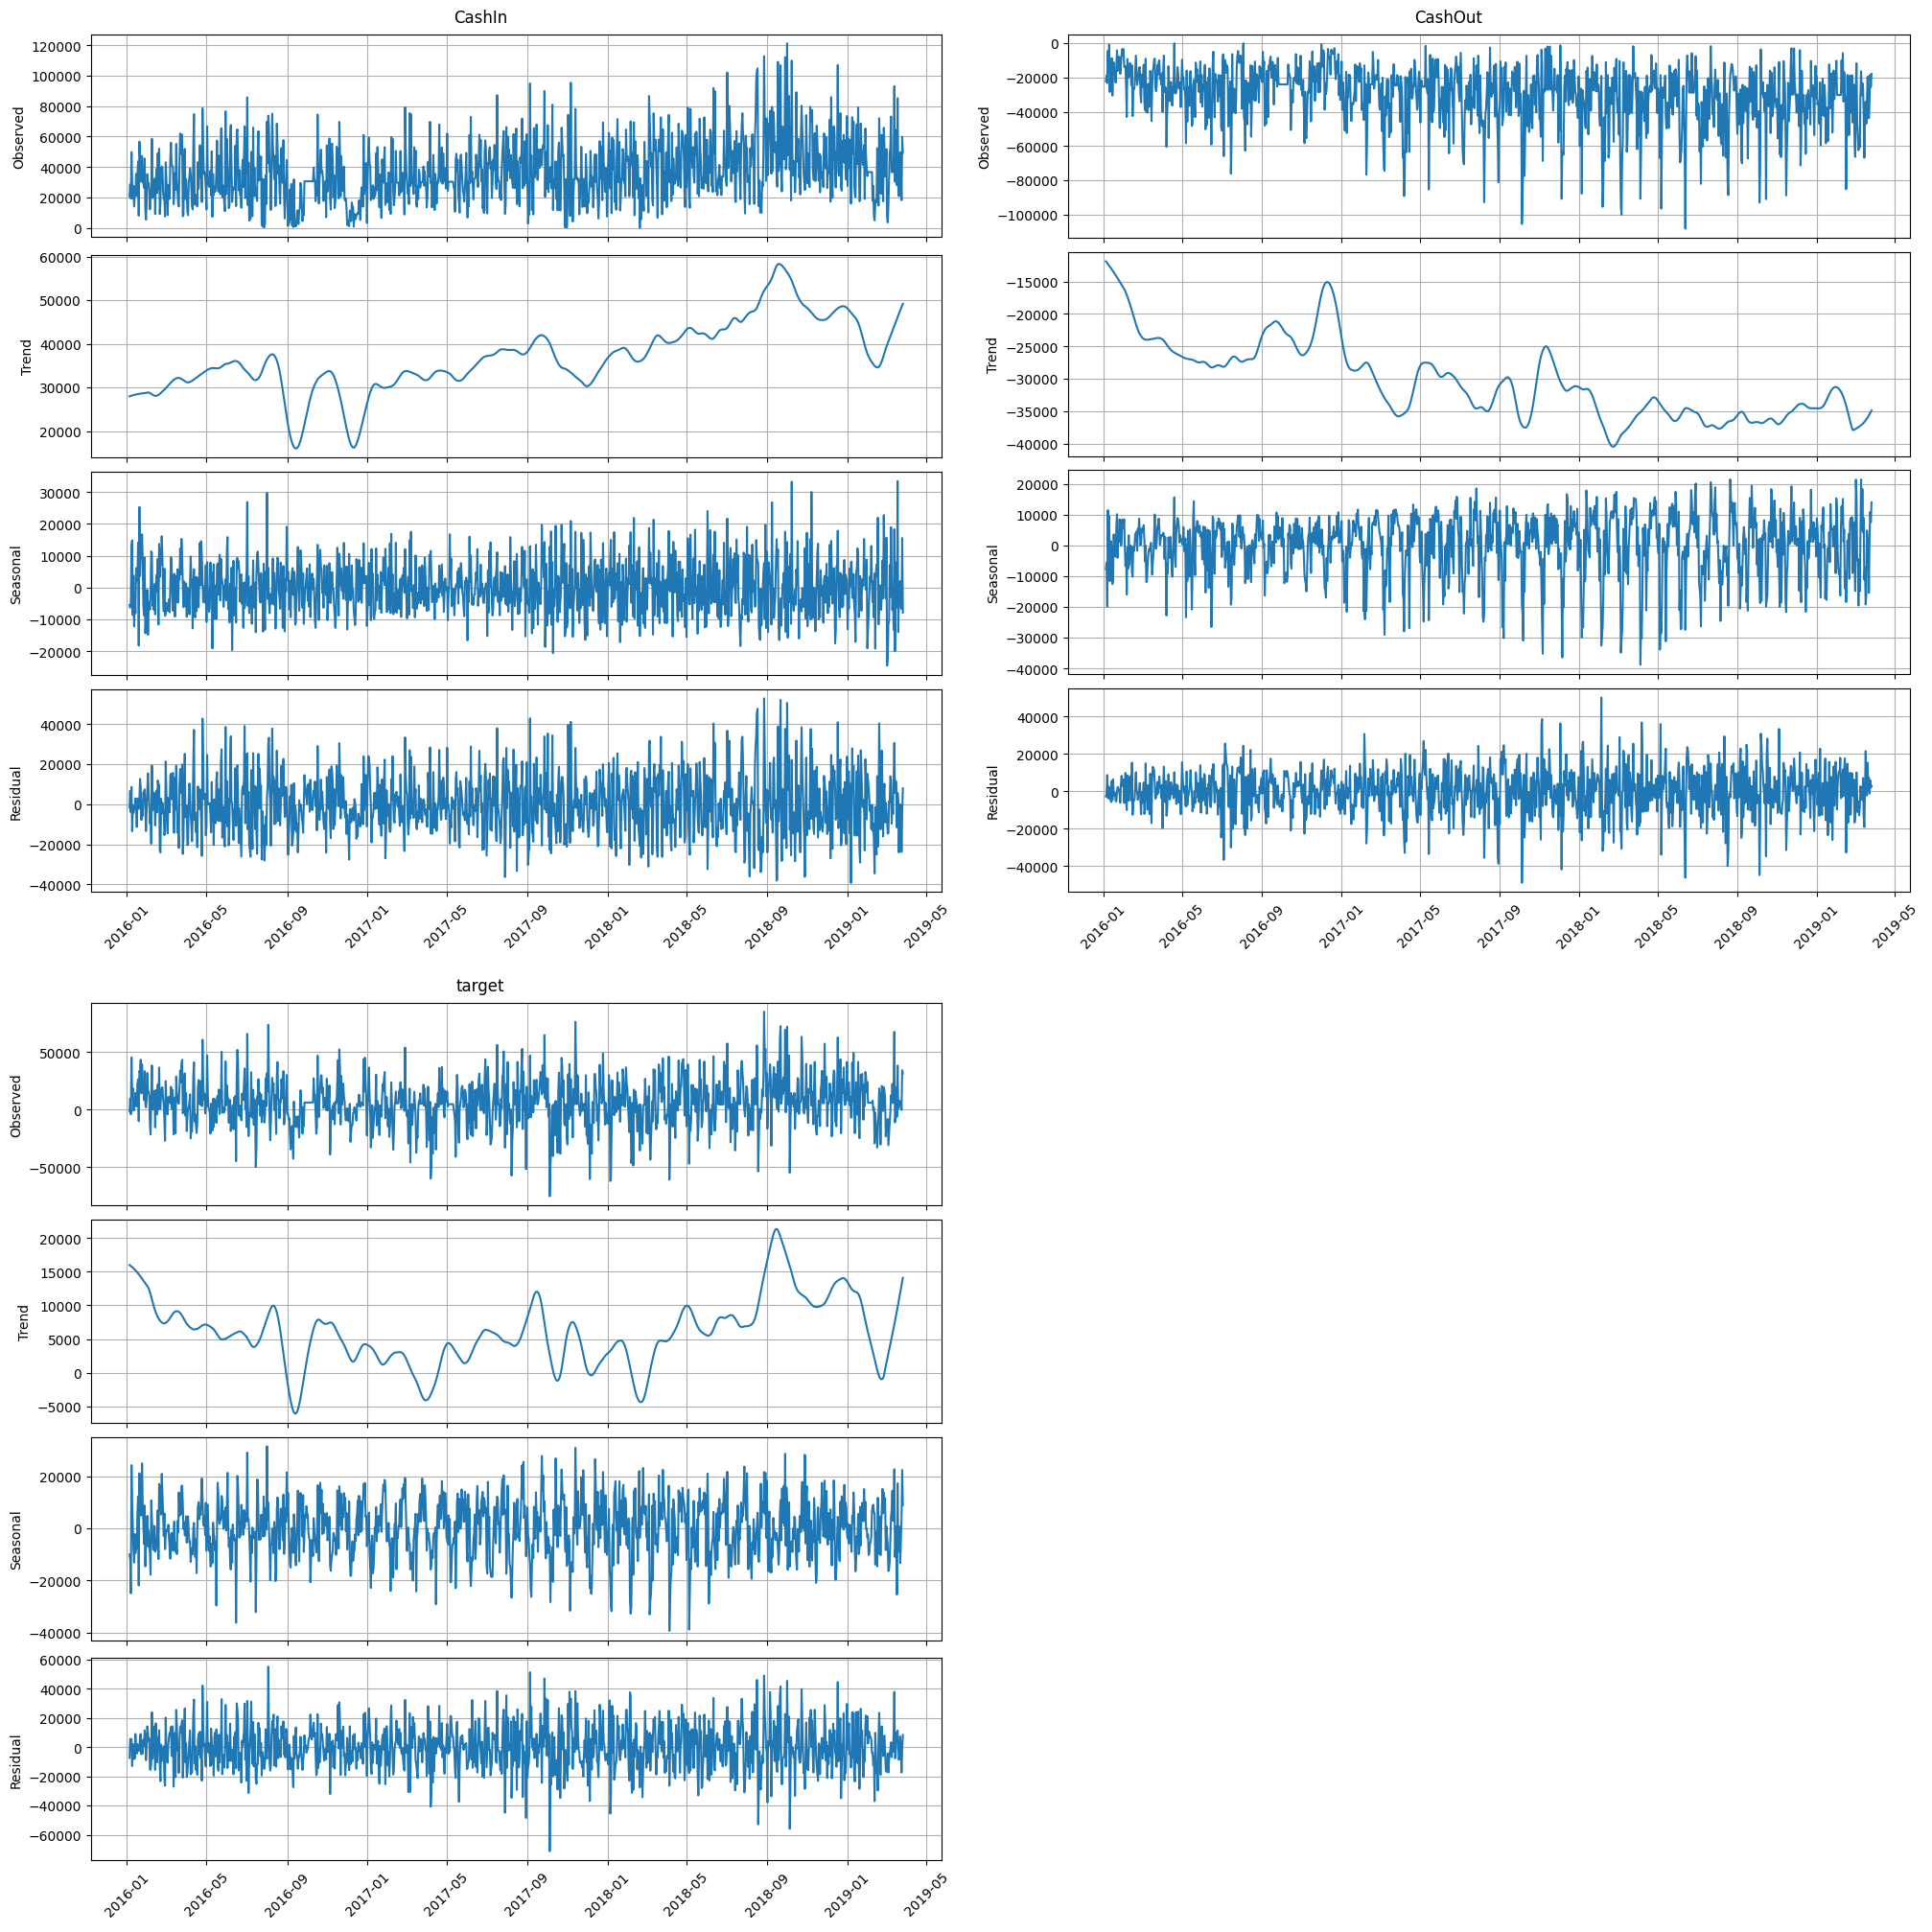

In [130]:
stl_plot(train_ts, period=30)

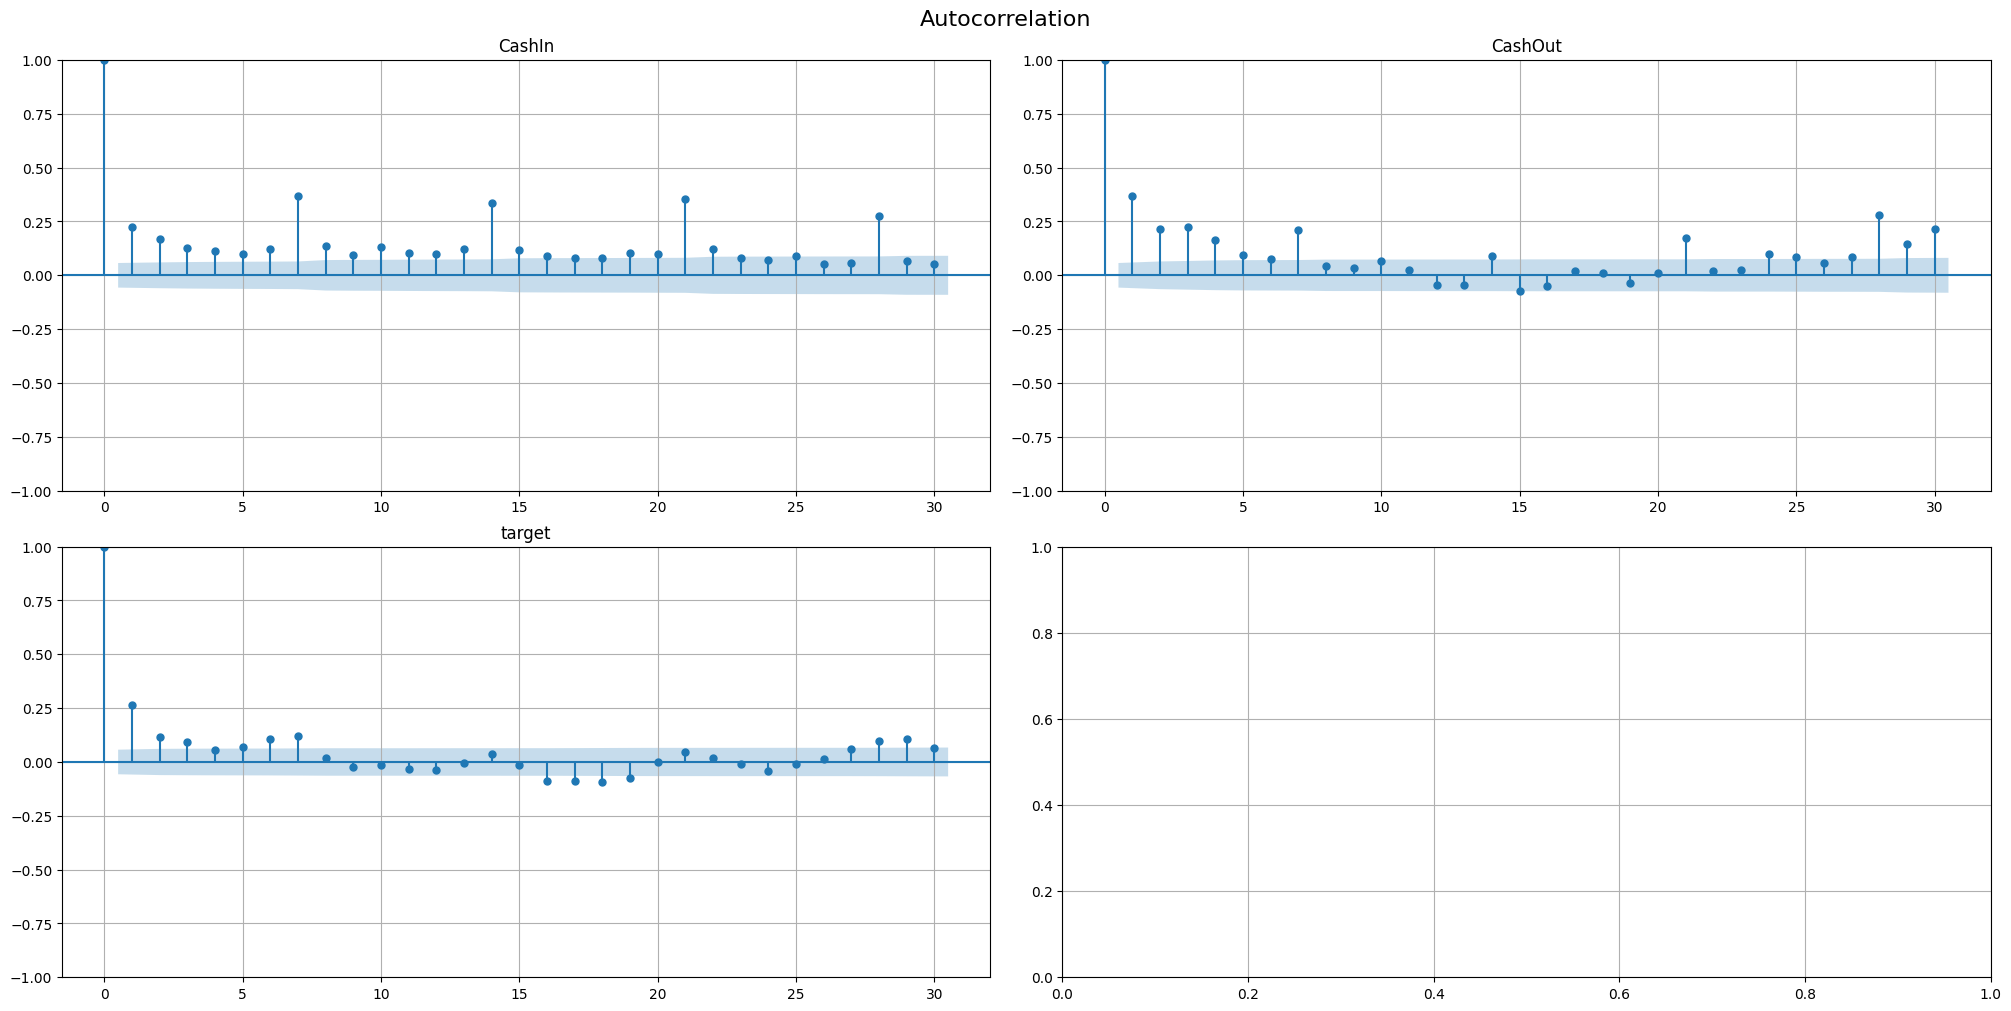

In [113]:
acf_plot(train_ts, n_segments=3, lags=30)

**ARIMA:**

Автокорреляция наблюдается в наблюдениях 7, 14, 21, 28 дней назад, то есть проселживается явная недельная сезонность. Это может быть связано с тем, что рабочие получают в конце недель зарплаты, а также с тем, что в конце недель они отдыхают, закупаются, для этого снимая деньги. 7 и 14, однако, слишком близкие, в сравнении с горизонтом прогнозирования, дни для аримы, поэтому выбраны дни подальше.

В качестве флагов выбраны особые дни - выходные, о их особенности написано выше. 

Минтрансформ усредняет значения по окну рабочей недели, так результаты лучше, вероятно, потому что модель становится менее чувствительна к каким-то внутренедельным выбросам.

Сегментный трансформер закодирует сегменты временных рядов в "расширяющееся среднее", не знаю что это, но работать стало лучше 👍.

In [65]:
lags_arima = LagTransform(in_column='target', lags=list(range(21, 29)), out_column="lag")
d_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    special_days_in_week=[5, 6])

pipeline = Pipeline(
    model=AutoARIMAModel(),
    transforms=[lags_arima, d_flags, 
                MeanSegmentEncoderTransform(),
                MeanTransform(in_column="target", window=5)
                ],
    horizon=5)

metrics, forecast, _ = pipeline.backtest(
    ts=train_ts, metrics=[SMAPE(), MAE()], n_folds=3, aggregate_metrics=True)
metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

segment       SMAPE           MAE
0   CashIn   33.569158  15856.351105
1  CashOut   30.692321  10284.749719
2   target  120.079194  14141.006150

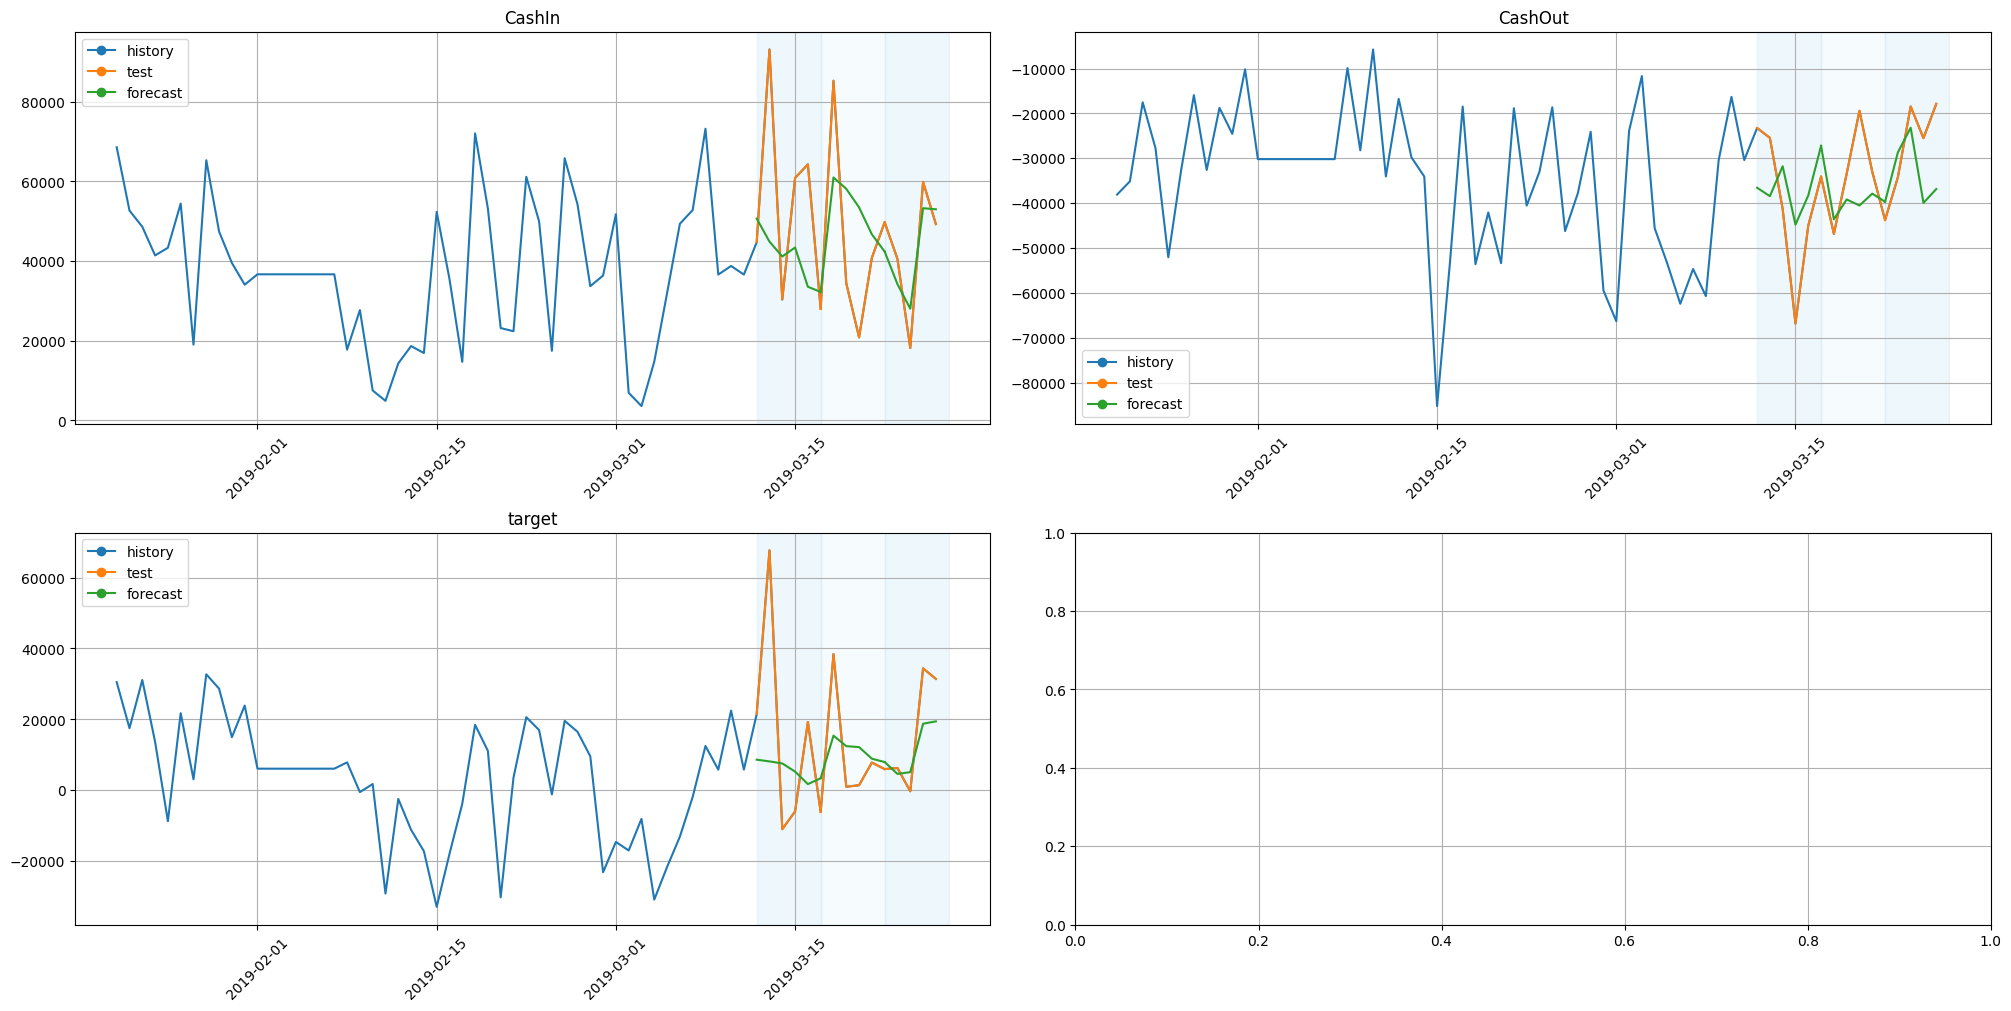

In [31]:
plot_backtest(forecast_df=forecast, ts=train_ts, history_len=50)

**CatBoost:**

Здесь все по прежнему, только включаются результаты стл-разложения и лаги учитываются за 1 и 7 дни, просто на основе корреляционного анализа наблюдений.

In [44]:
lags_catboost = LagTransform(in_column='target', lags=[1, 7], out_column="lag")

pipeline = Pipeline(
    model = CatBoostPerSegmentModel(),
    transforms=[STLTransform(in_column='target', period=30),
                lags_catboost, MeanSegmentEncoderTransform(),
                d_flags, MeanTransform(in_column="target", window=5),
                ],
    horizon=5,)

metrics_cat_base, forecast_cat_base, _ = pipeline.backtest(
    ts=train_ts, metrics=[SMAPE(), MAE()], n_folds=5, aggregate_metrics=True)
metrics_cat_base

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

segment       SMAPE           MAE
0   CashIn   69.929954  26667.729058
1  CashOut   56.030476  16298.474977
2   target  100.074231  17441.750427

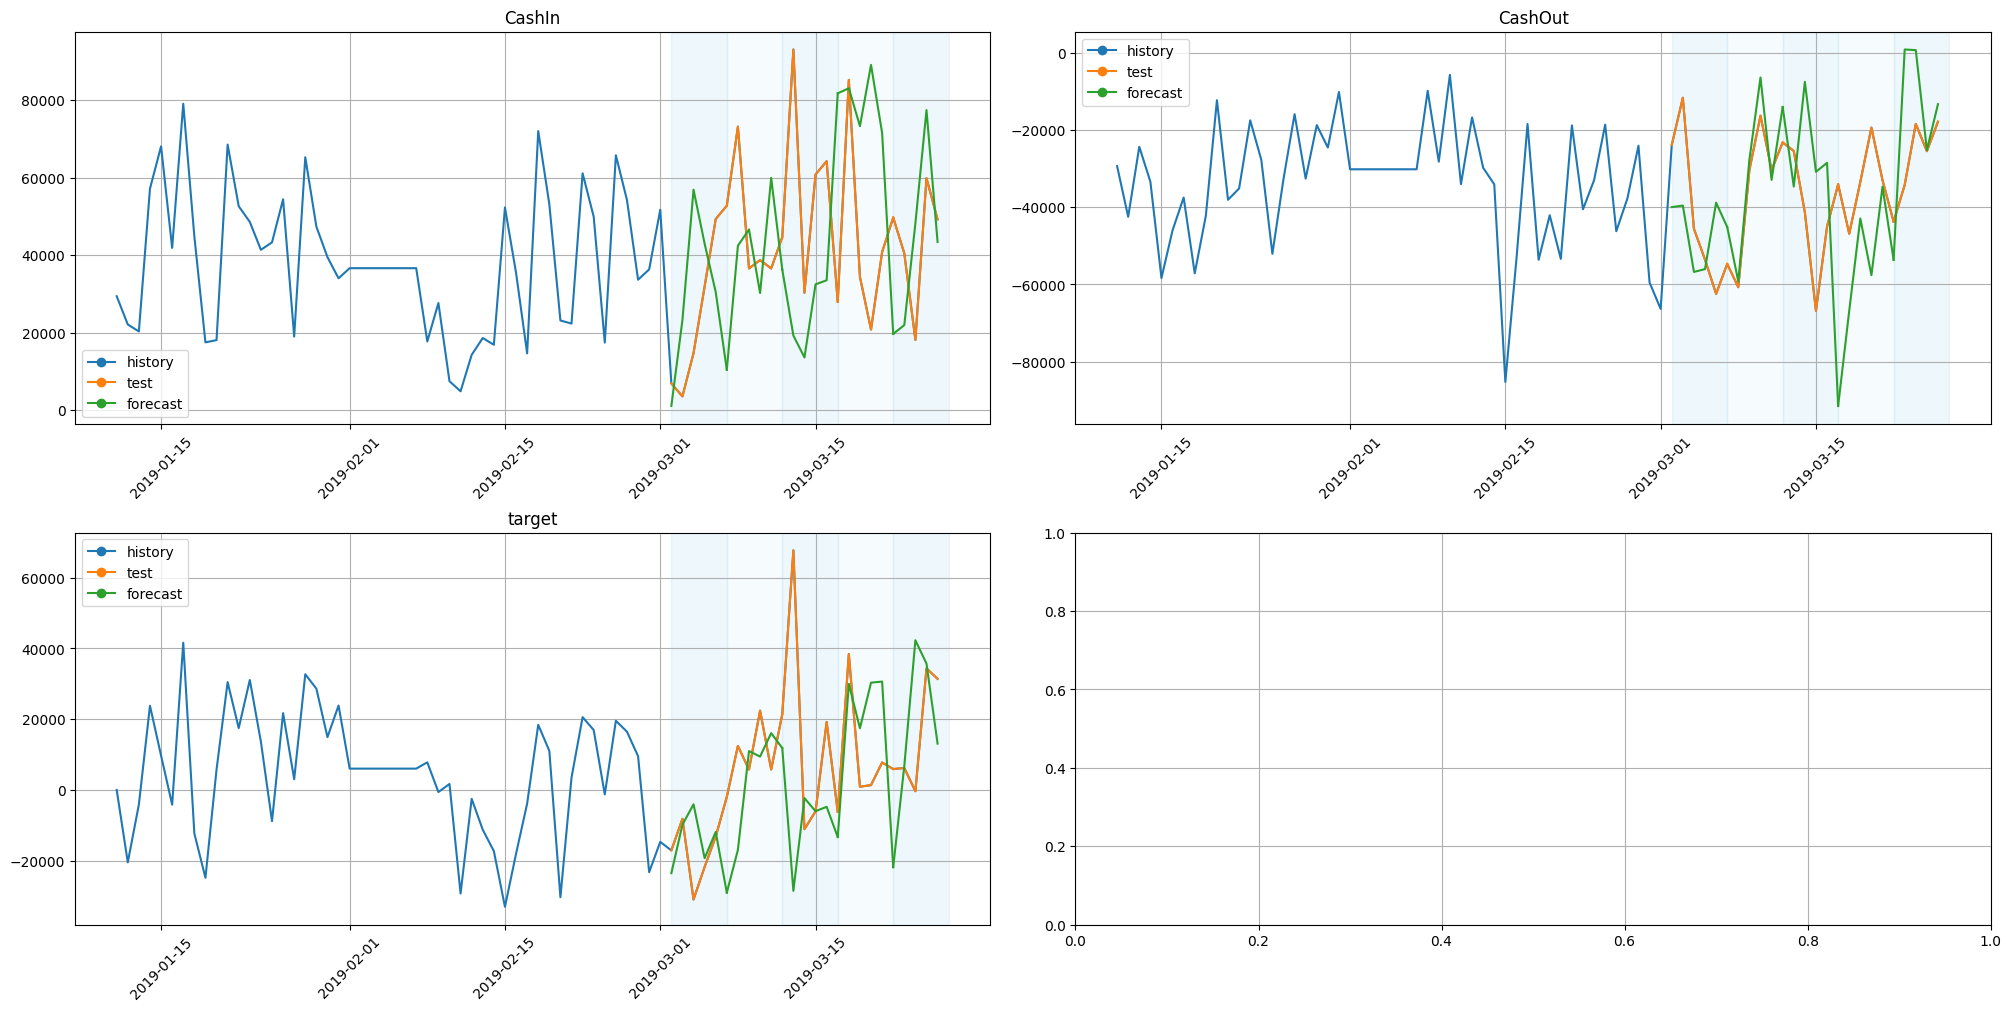

In [45]:
plot_backtest(forecast_df=forecast_cat_base, ts=train_ts, history_len=50)

In [33]:
pipeline = Pipeline(
    model = CatBoostMultiSegmentModel(),
    transforms=[STLTransform(in_column='target', period=30),
                lags_catboost, MeanSegmentEncoderTransform(),
                d_flags, MeanTransform(in_column="target", window=5),
                ],
    horizon=5,)

metrics, forecast, _ = pipeline.backtest(
    ts=train_ts, metrics=[SMAPE(), MAE()], n_folds=5, aggregate_metrics=True)
metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   39.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

segment       SMAPE           MAE
0   CashIn   59.791458  26513.495878
1  CashOut   49.413610  15787.694375
2   target  106.560518  17695.439462

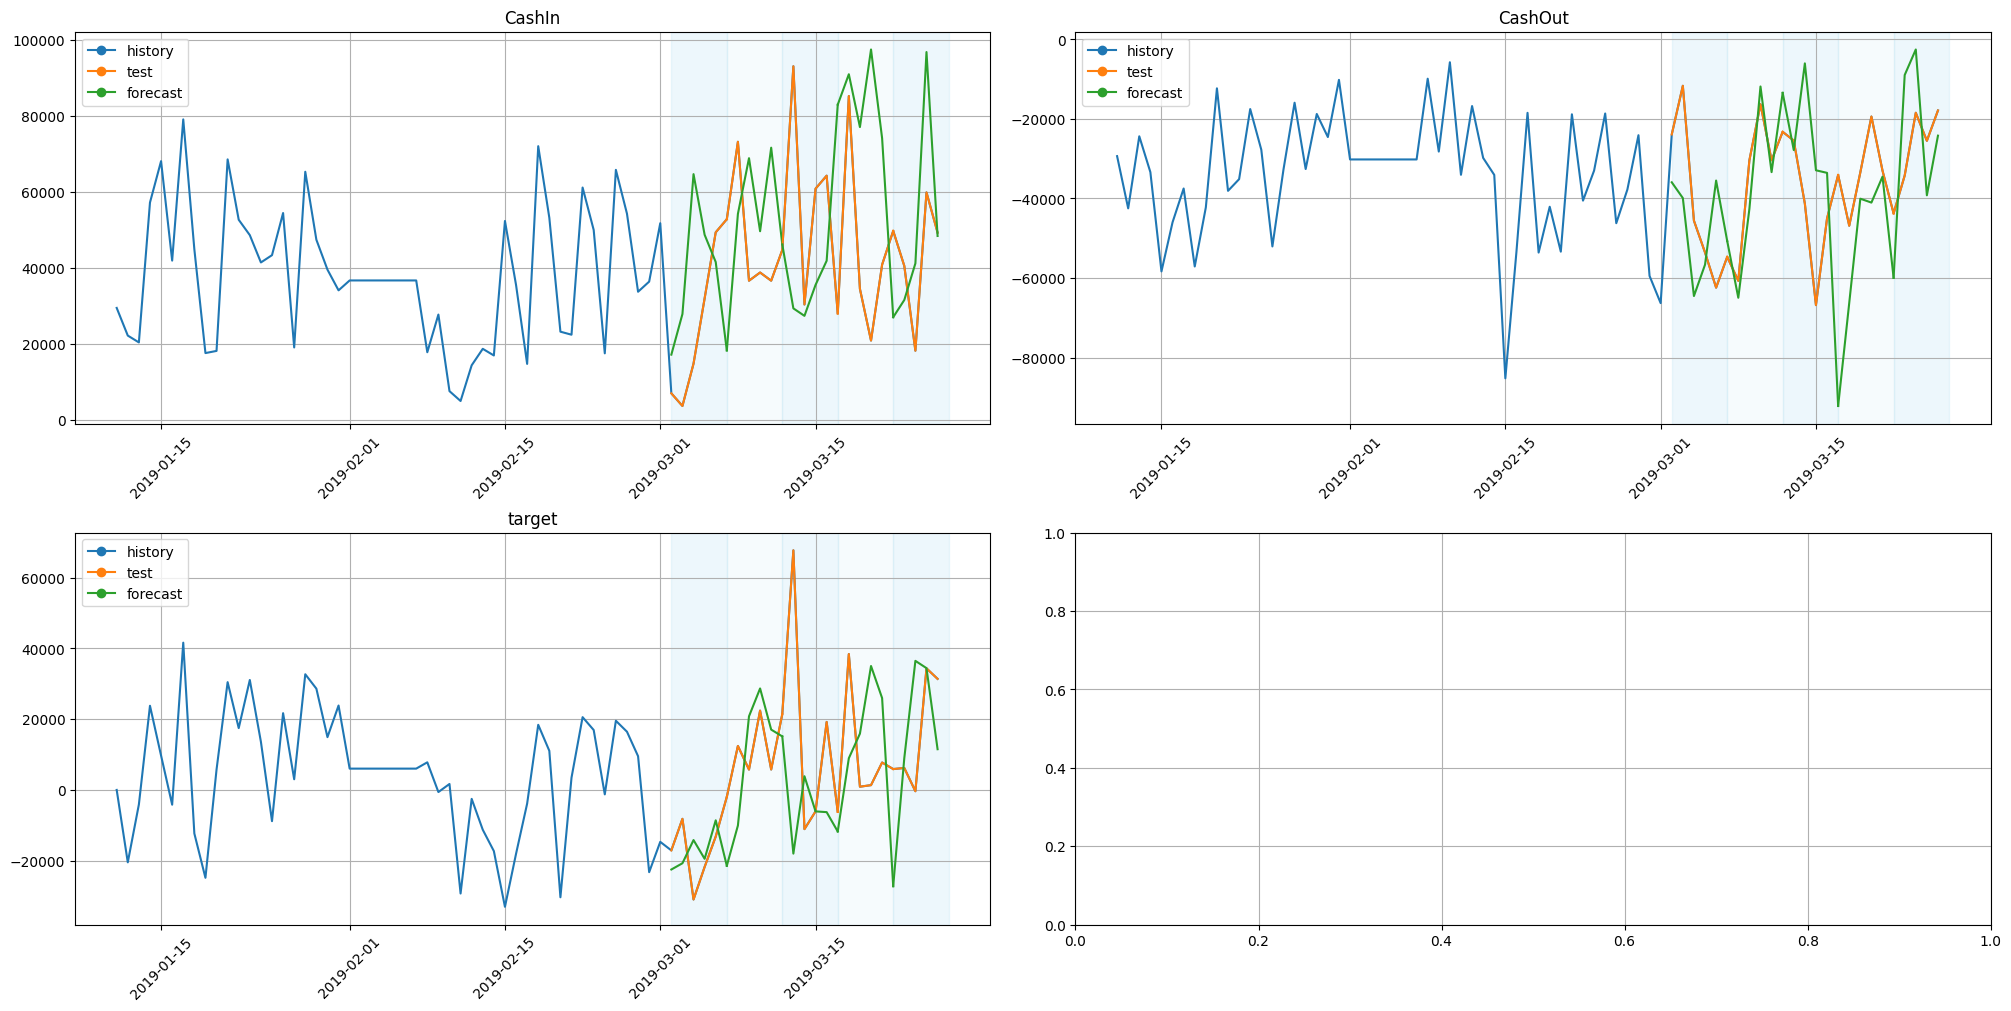

In [139]:
plot_backtest(forecast_df=forecast, ts=train_ts, history_len=50)

### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [35]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

**Рекуррентная авторегрессионная стратегия**

CatBoost:

In [36]:
pipeline = AutoRegressivePipeline(
    model = CatBoostMultiSegmentModel(),
    transforms=[STLTransform(in_column='target', period=30),
                lags_catboost, MeanSegmentEncoderTransform(),
                d_flags, MeanTransform(in_column="target", window=5),
                ],
    horizon=5, step=5)

metrics_rec_cat, forecast_rec_cat, _ = pipeline.backtest(
    ts=train_ts, metrics=[SMAPE(), MAE()], n_folds=5, aggregate_metrics=True)
metrics

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   49.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

segment       SMAPE           MAE
0   CashIn   59.791458  26513.495878
1  CashOut   49.413610  15787.694375
2   target  106.560518  17695.439462

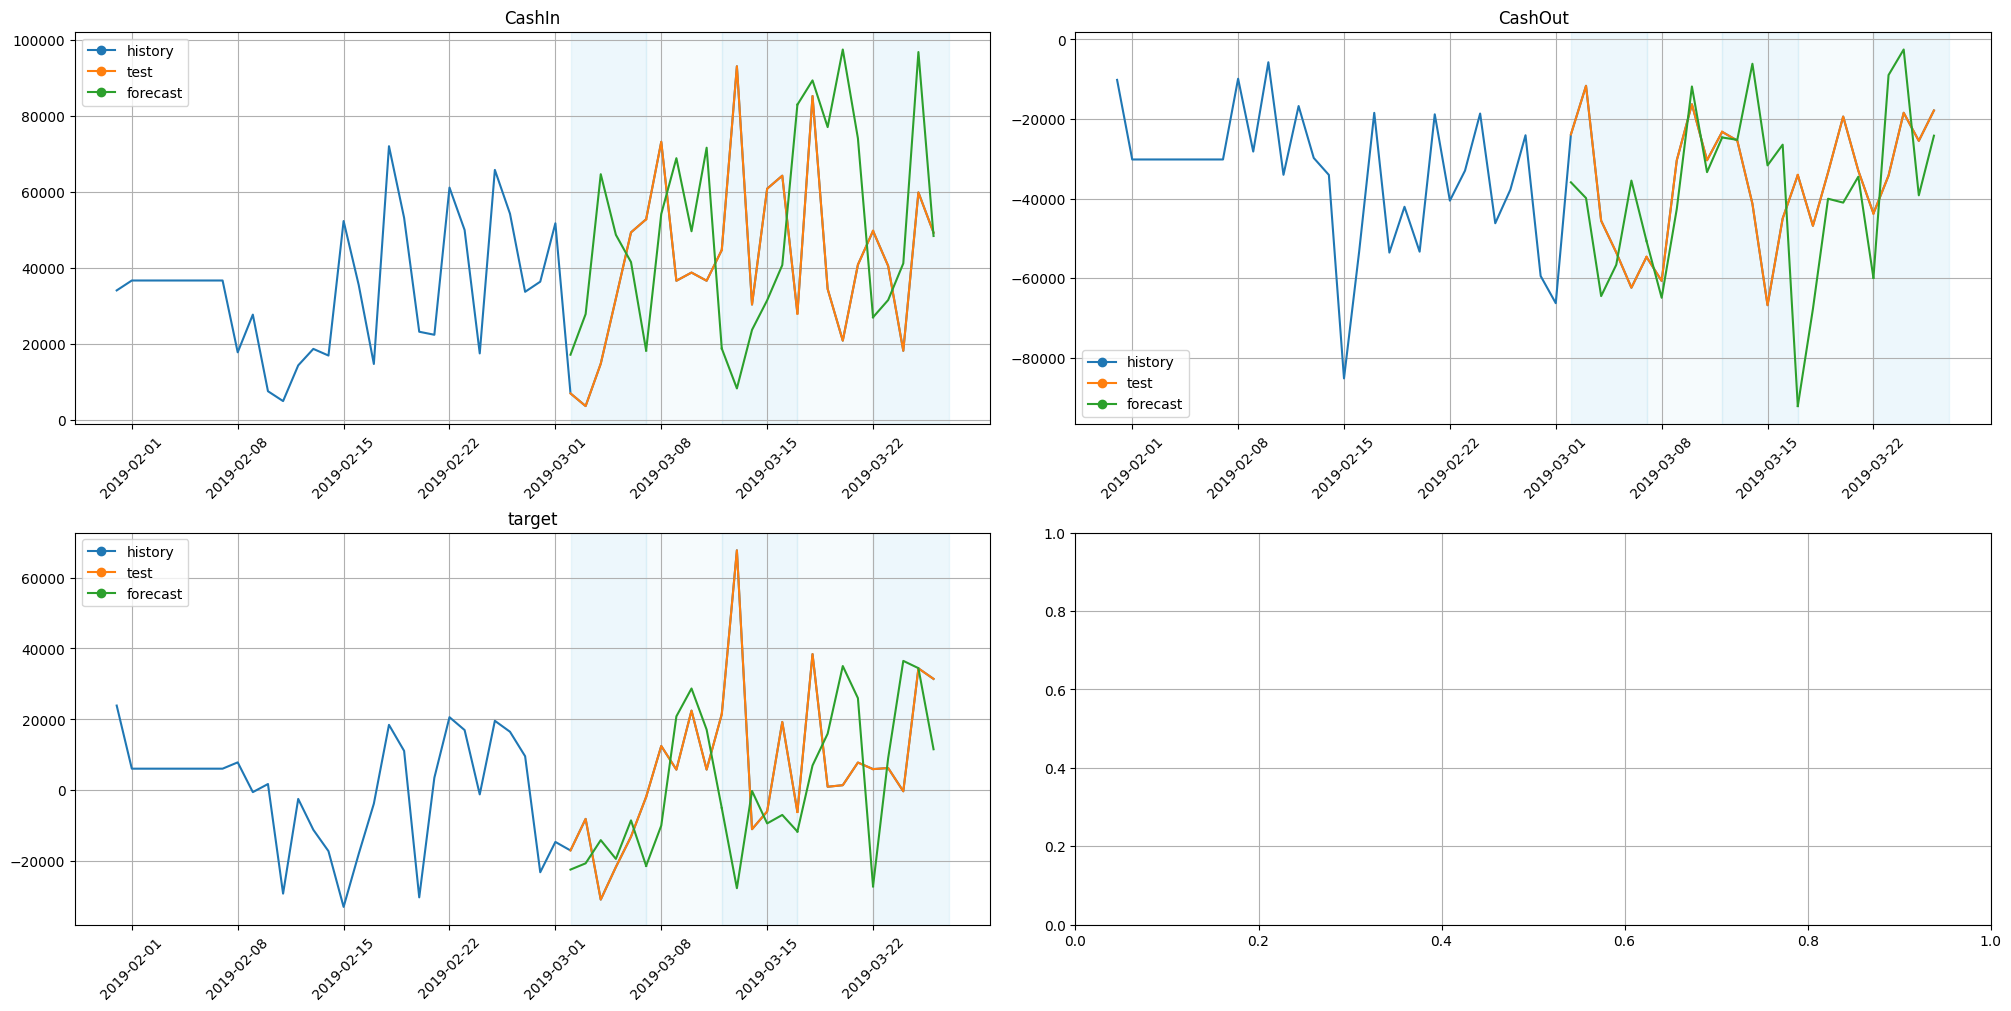

In [37]:
plot_backtest(forecast_rec_cat, train_ts, history_len=30)

ARIMA:

In [38]:
lags_arima = LagTransform(in_column='target', lags=list(range(21, 29)), out_column="lag")
d_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    special_days_in_week=[5, 6])

pipeline = AutoRegressivePipeline(
    model=AutoARIMAModel(),
    transforms=[lags_arima, d_flags, 
                MeanSegmentEncoderTransform(),
                MeanTransform(in_column="target", window=5)
                ],
    horizon=5, step=5)

metrics_rec_arma, forecast_rec_arma, _ = pipeline.backtest(
    ts=train_ts, metrics=[SMAPE(), MAE()], n_folds=3, aggregate_metrics=True)
metrics_rec_arma

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0

segment       SMAPE           MAE
0   CashIn   33.569158  15856.351105
1  CashOut   30.692321  10284.749719
2   target  120.079194  14141.006150

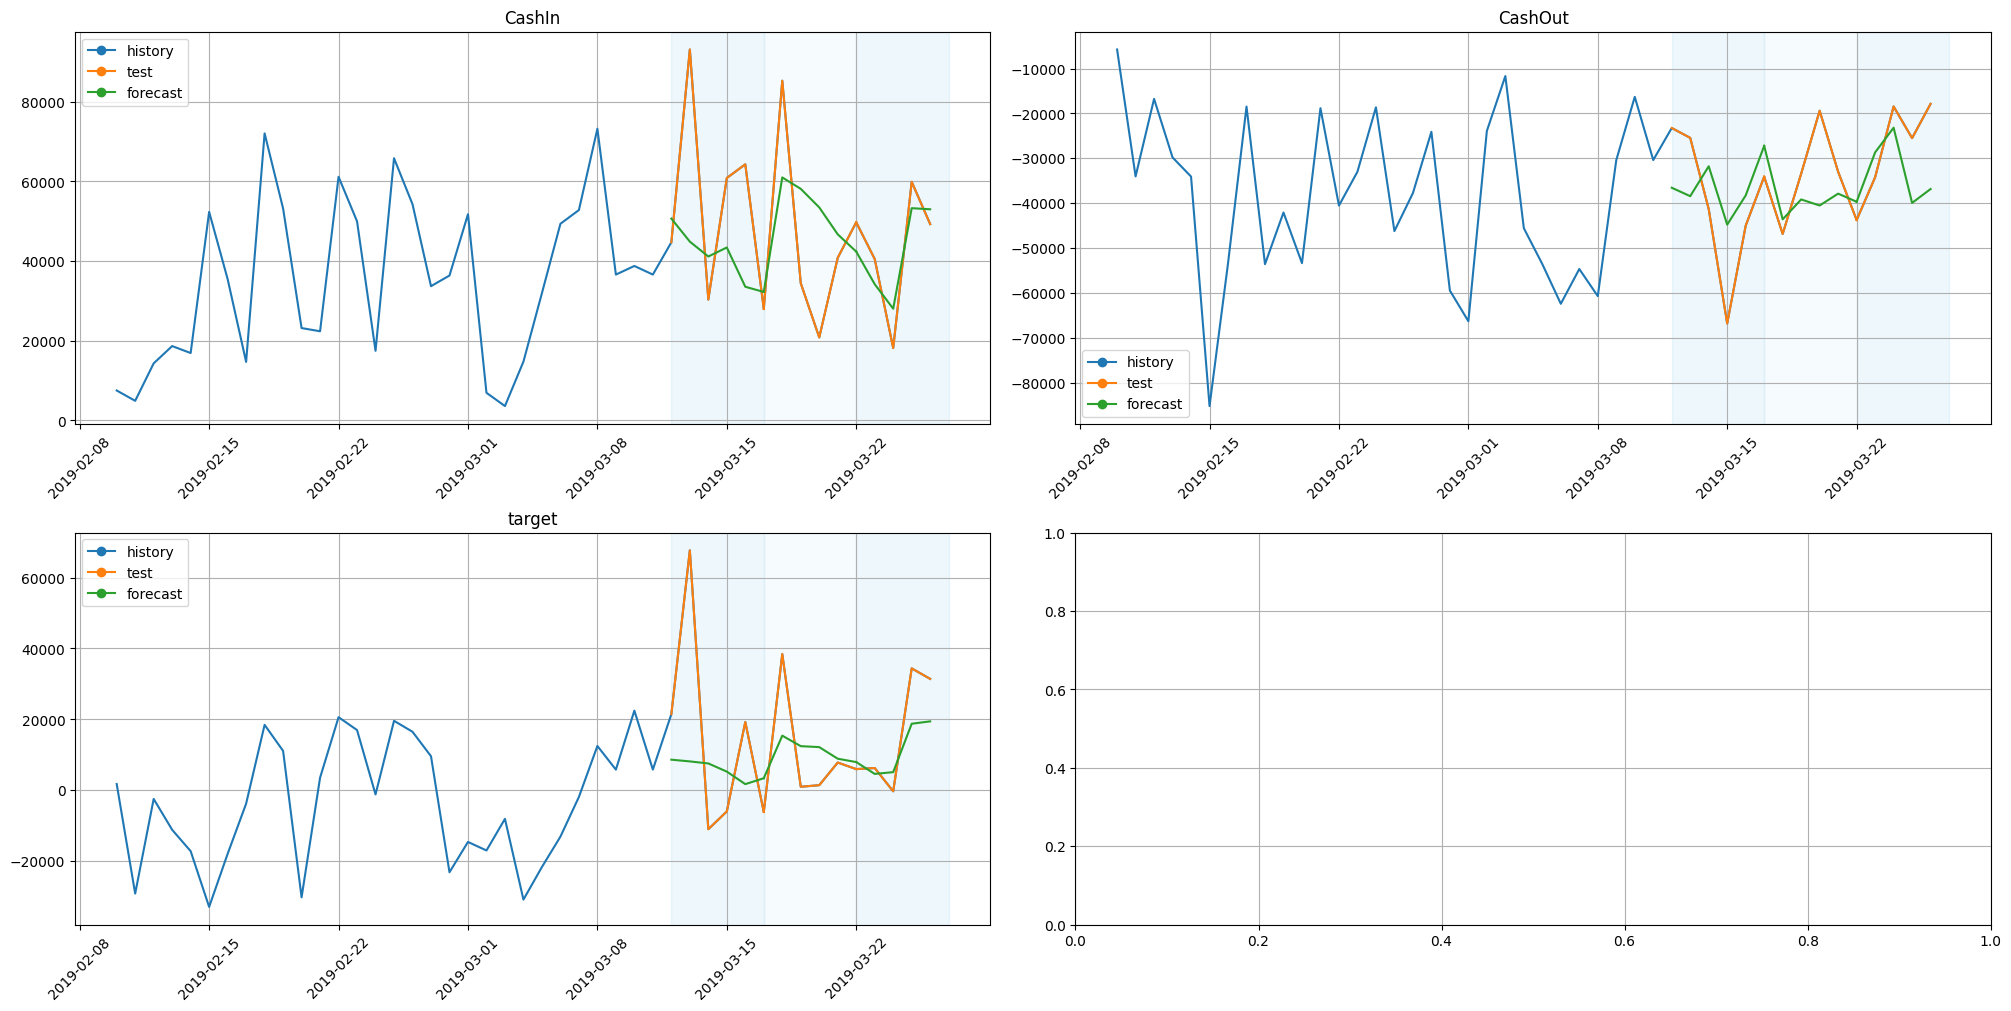

In [39]:
plot_backtest(forecast_rec_arma, train_ts, history_len=30)

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [41]:
HORIZON = 5
lags_catboost = LagTransform(in_column='target', lags=[1, 7], out_column="lag")
lags_arima = LagTransform(in_column='target', lags=list(range(21, 29)), out_column="lag")
d_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    special_days_in_week=[5, 6])


pipeline1 = Pipeline(
    model = CatBoostPerSegmentModel(),
    transforms=[STLTransform(in_column='target', period=30),
                lags_catboost, MeanSegmentEncoderTransform(),
                d_flags, MeanTransform(in_column="target", window=5),
                ],
    horizon=HORIZON)

pipeline2 = AutoRegressivePipeline(
    model=AutoARIMAModel(),
    transforms=[lags_arima, d_flags, 
                MeanSegmentEncoderTransform(),
                MeanTransform(in_column="target", window=5)
                ],
    horizon=5, step=5)


pipeline_names = ["per-segment CatBoost", "reccursive ARIMA"]
pipelines = [pipeline1, pipeline2]

Создадим ансамбль, с весами, заданными из соотношения средних ошибок SMAPE.

In [61]:
means = [metrics_cat_base['SMAPE'].mean(), metrics_rec_arma['SMAPE'].mean()]
weights = means / np.sum(means)

voting_ensemble = VotingEnsemble(pipelines=pipelines, weights=weights.tolist(), n_jobs=4)

In [63]:
voting_ensamble_metrics, forecast_ensamble, _ = voting_ensemble.backtest(
    ts=train_ts,
    metrics=[MAE(), SMAPE()],
    n_folds=5,
    aggregate_metrics=True,
    n_jobs=2,
)
voting_ensamble_metrics

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   33.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   33.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed: 12.2min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed: 12.2min finished
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 12.2min
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed: 12.6min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed: 12.6min finished
[Parallel(n_jobs=4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed: 12.6min
[Paralle

segment           MAE       SMAPE
0   CashIn  21086.526554   53.324453
1  CashOut  12348.282329   36.490334
2   target  14995.517351  112.179202

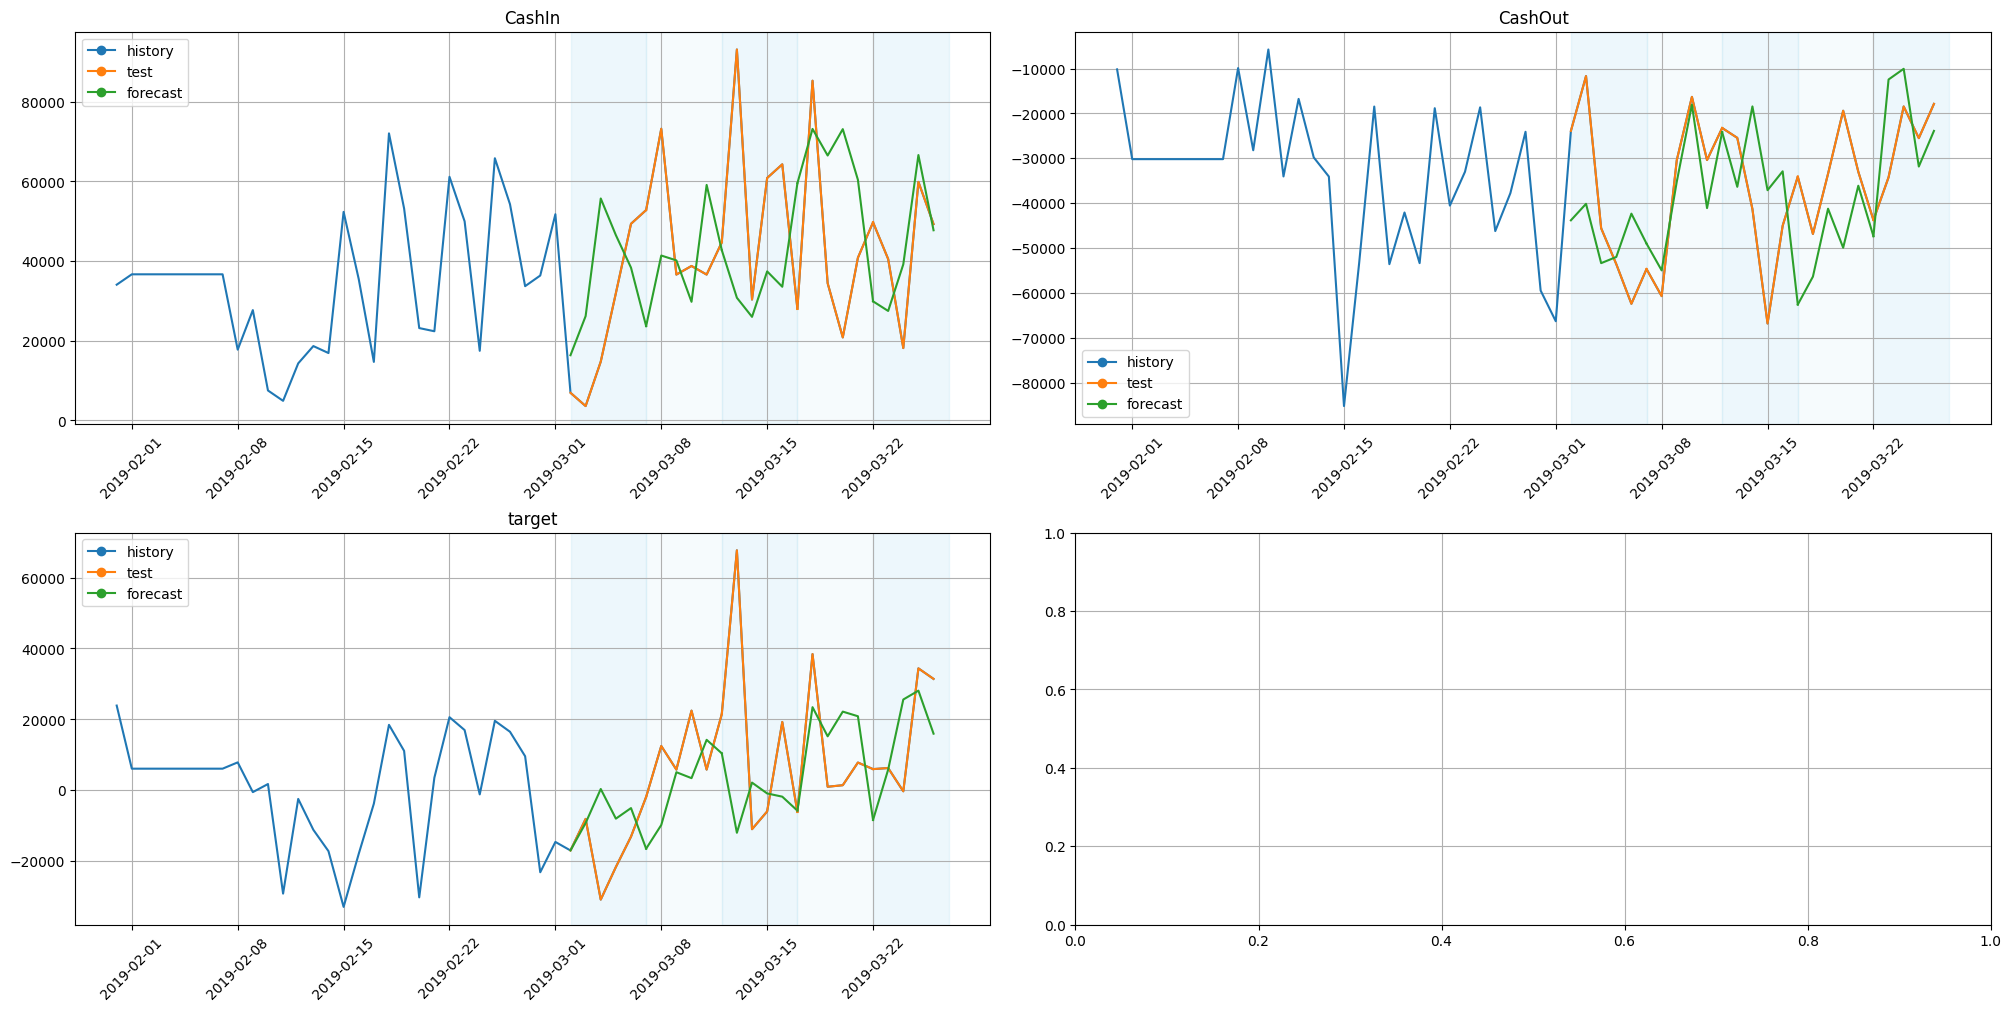

In [64]:
plot_backtest(forecast_ensamble, train_ts, history_len=30)

По МАЕ оценки - лучшие из полученных в данной тетрадке. Достигнуто это, очевидно, за счет ансамблирования разных моделей, каждая из которых ловит разные закономерности.

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#